### Assemble 2m temperature dataset from ERA5

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import dask
import matplotlib.pyplot as plt

In [2]:
# open 2m temperature files
ds = xr.open_mfdataset(
    "/glade/campaign/collections/rda/data/d633000/e5.oper.fc.sfc.minmax/*/e5.oper.fc.sfc.minmax.128_201_mx2t.ll025sc.*.nc"
)

# stack the forecast and initialized dims
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    da = ds.stack(datetime=["forecast_initial_time", "forecast_hour"])["MX2T"]

# create datetime vector and assign
dt_array = pd.date_range(start="1940-01-01 06:00:00", freq="1H", periods=len(da.datetime))
da = da.drop_vars({'forecast_hour', 'forecast_initial_time', 'datetime'}).assign_coords(datetime=dt_array)

# Monthly mean daily max 2m temperature
da_mx2t_monthly_mean_grid = da.resample(datetime="1D").max().resample(datetime="MS").mean()
da_mx2t_monthly_mean_grid.to_netcdf("/glade/derecho/scratch/molina/bams_grid_sample.nc")

# global mean time series
weights = np.cos(np.deg2rad(da.latitude))
weights.name = "weights"
da_timeseries = da_mx2t_monthly_mean_grid.weighted(weights).mean(("longitude", "latitude"), skipna=True)
da_timeseries.to_netcdf("/glade/derecho/scratch/molina/bams_timeseries_sample.nc")

### Assemble mean total precipitation rate dataset from ERA5

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import dask
import matplotlib.pyplot as plt

In [2]:
def preprocess(ds):
    return ds.sel(latitude=slice(37, 8), longitude=slice(68, 97)) # indian monsoon region

# open precip files
ds = xr.open_mfdataset(
    "/glade/campaign/collections/rda/data/d633000/e5.oper.fc.sfc.meanflux/*/e5.oper.fc.sfc.meanflux.235_055_mtpr.ll025sc.*.nc",
    preprocess=preprocess
)

# stack the forecast and initialized dims
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    da = ds.stack(datetime=["forecast_initial_time", "forecast_hour"])["MTPR"]

# create datetime vector and assign
dt_array = pd.date_range(start="1940-01-01 06:00:00", freq="1H", periods=len(da.datetime))
da = da.drop_vars({'forecast_hour', 'forecast_initial_time', 'datetime'}).assign_coords(datetime=dt_array)

# Daily mean total precip rate, max value in monsoon region
da_mtpr_daily_mean_maxval = da.resample(datetime="1D").mean(skipna=True).max(["latitude", "longitude"], skipna=True) * 86400

# save file
da_mtpr_daily_mean_maxval.to_netcdf("/glade/derecho/scratch/molina/bams_mtpr_timeseries_sample.nc")

/glade/derecho/scratch/molina/tmp/ipykernel_16206/1231339797.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dt_array = pd.date_range(start="1940-01-01 06:00:00", freq="1H", periods=len(da.datetime))


### Demo different transformation and scaling for total mean precipitation rate

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import dask
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import gaussian_kde, linregress, pearsonr

In [2]:
def boxcox_transform(y, lam):
    if lam == 0:
        return np.log(y)
    else:
        return (y**lam - 1) / lam

def yeo_johnson_transform(y, lam):
    """
    Apply the Yeo-Johnson transformation to a 1D array.
    
    Parameters:
    - y: Input array (1D)
    - lam: Lambda parameter
    """
    y_transformed = np.zeros_like(y, dtype=np.float64)

    # Case 1: y >= 0, lambda != 0
    pos = (y >= 0) & (lam != 0)
    y_transformed[pos] = ((y[pos] + 1)**lam - 1) / lam

    # Case 2: y >= 0, lambda == 0
    pos_zero = (y >= 0) & (lam == 0)
    y_transformed[pos_zero] = np.log(y[pos_zero] + 1)

    # Case 3: y < 0, lambda != 2
    neg = (y < 0) & (lam != 2)
    y_transformed[neg] = -((-y[neg] + 1)**(2 - lam) - 1) / (2 - lam)

    # Case 4: y < 0, lambda == 2
    neg_two = (y < 0) & (lam == 2)
    y_transformed[neg_two] = -np.log(-y[neg_two] + 1)

    return y_transformed

def compute_kde(data):
    if type(data)==xr.core.dataarray.DataArray:
        data = data.values
    kde = gaussian_kde(data)
    x = np.linspace(min(data), max(data), 1000)  # Generate x values for the curve
    return x, kde(x)

def detrend(arr, time_array, deg=1):
    """
    Detrend a 1D array or grouped data by removing a polynomial trend.
    """
    x = time_array
    coeffs = np.polyfit(x, arr, deg=deg) # Fit the polynomial
    trend = np.polyval(coeffs, x) # Generalized trend calculation
    return arr - trend

def compute_rolling_mean(group, window=30):
    # Apply rolling mean to the grouped data
    rolling_mean = group.rolling(datetime=window, min_periods=1, center=True).mean(skipna=True)
    return rolling_mean

def rolling_month(group):
    return group.rolling(datetime=30, min_periods=1, center=True).mean(skipna=True)

def month_year_create(yr_array):
    return yr_array + np.tile(np.arange(0.,1.,1/12), len(np.unique(yr_array)))[:yr_array.shape[0]]

def percent_diff(mean1, mean2):
    return ((mean1 - mean2) / mean2) * 100

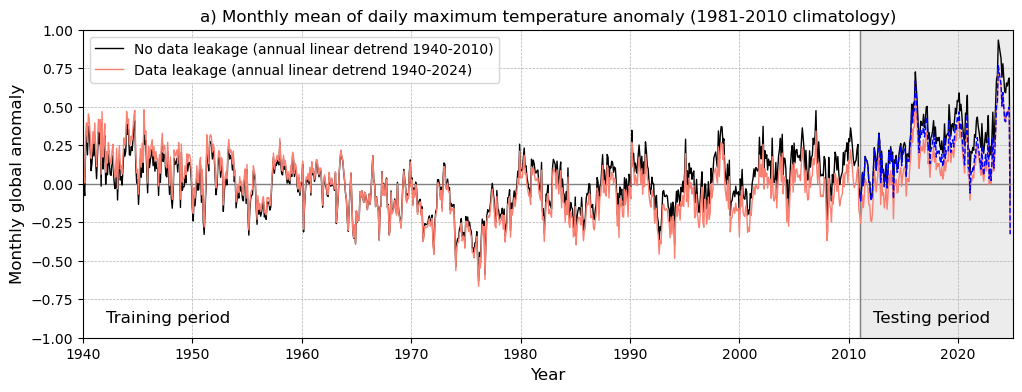

In [5]:
########################################## open time series monthly 2m temp max

dsts = xr.open_dataset("/glade/derecho/scratch/molina/bams_timeseries_sample.nc")['MX2T']

# 1981-2010 fixed monthly climatology
clim1 = dsts.sel(datetime=slice("1981-01-01", "2010-12-31")).groupby('datetime.month').mean(skipna=True)
an1 = dsts.groupby('datetime.month') - clim1

########################################## figure time

plt.figure(figsize=(12,4))

plt.axvspan(2011, 2025, color='gray', alpha=0.15)

# plot horizontal line at zero
plt.hlines(
    y=0, 
    xmin=month_year_create(an1.datetime.dt.year.values)[0], 
    xmax=month_year_create(an1.datetime.dt.year.values)[-1], 
    lw=1, ls='-', colors='grey'
)

# plot horizontal line at zero
plt.vlines(
    x=2011, 
    ymin=-1, 
    ymax=1, 
    lw=1, ls='-', colors='grey'
)

########################################## annual detrend training period (no leakage)

trend_data = an1.sel(datetime=slice("1940-01-01", "2010-12-31")).resample(datetime="YS").mean(skipna=True)
# annual climo years
x_trend = trend_data.datetime.dt.year.values
# coeffs
coeffs = np.polyfit(x_trend, trend_data, deg=1)

# line 1
line_1_ = an1 - np.polyval(coeffs, month_year_create(an1.datetime.dt.year.values))

# detrend all data with 1981-2010 trendline
plt.plot(
    month_year_create(an1.datetime.dt.year.values), 
    line_1_, 
    c='k', lw=1., label="No data leakage (annual linear detrend 1940-2010)"
)

########################################## annual detrend everything (leakage)

trend_data = an1.resample(datetime="YS").mean(skipna=True)
# annual climo years
x_trend = trend_data.datetime.dt.year.values
# coeffs
coeffs = np.polyfit(x_trend, trend_data, deg=1)

# line 2
line_2_ = an1 - np.polyval(coeffs, month_year_create(an1.datetime.dt.year.values))

# detrend all data with 1981-2010 trendline
plt.plot(
    month_year_create(an1.datetime.dt.year.values), 
    line_2_, 
    c='salmon', lw=1., label="Data leakage (annual linear detrend 1940-2024)"
)

##########################################

# dynamic detrending
years = an1.resample(datetime="YS").mean(skipna=True).datetime.dt.year
time_series = an1.resample(datetime="YS").mean(skipna=True)

for num, i in enumerate(np.arange(2010, 2025, 1)):
    
    f_years = years.sel(datetime=slice(f"1940-01-01", f"{i}-12-31"))
    f_data = time_series.sel(datetime=slice(f"1940-01-01", f"{i}-12-31"))
    
    coeffs = np.polyfit(f_years, f_data, deg=1)

    if num == 0:
        trend = np.polyval(
            coeffs, month_year_create(an1.sel(datetime=slice(f"1940-01-01", f"{i}-12-31")).datetime.dt.year.values)
        )
        ds0 = an1.sel(datetime=slice(f"1940-01-01", f"{i}-12-31")) - trend
        
    if num > 0:
        trend = np.polyval(
            coeffs, month_year_create(an1.sel(datetime=slice(f"{i}-01-01", f"{i}-12-31")).datetime.dt.year.values)
        )
        ds1 = an1.sel(datetime=slice(f"{i}-01-01", f"{i}-12-31")) - trend
        ds0 = xr.concat([ds0, ds1], dim="datetime")


# detrend all data with 1981-2010 trendline
plt.plot(
    month_year_create(an1.sel(datetime=slice('2011-01-01','2024-10-02')).datetime.dt.year.values), 
    ds0.sel(datetime=slice('2011-01-01','2024-10-02')), 
    c='b', ls='--', lw=1.
)

##########################################

plt.ylabel('Monthly global anomaly', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(ls='--', lw=0.5)
plt.margins(x=0, y=0)
plt.annotate(
    'Training period', fontsize=12, 
    xy=(0.025, 0.05), xycoords='axes fraction', 
    xytext=(0.025, 0.05), textcoords='axes fraction'
)
plt.annotate(
    'Testing period', fontsize=12, 
    xy=(0.85, 0.05), xycoords='axes fraction', 
    xytext=(0.85, 0.05), textcoords='axes fraction'
)
plt.title('a) Monthly mean of daily maximum temperature anomaly (1981-2010 climatology)', fontsize=12)
plt.legend()
plt.show()

##########################################

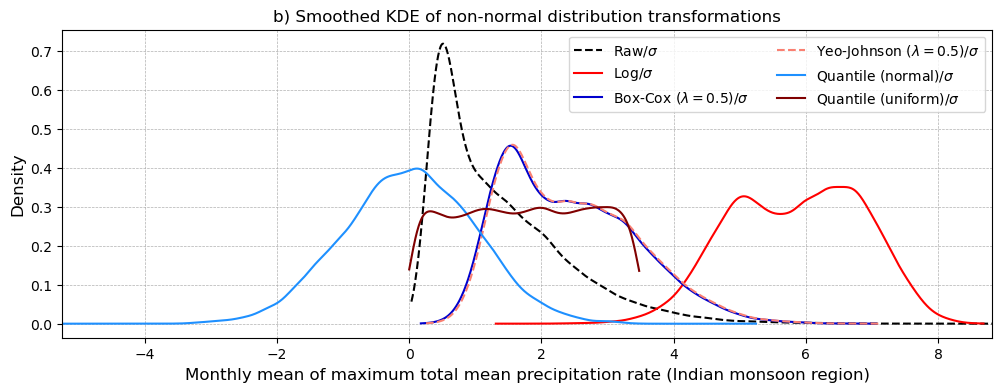

In [4]:
# RAW DATA
dstp = xr.open_dataset("/glade/derecho/scratch/molina/bams_mtpr_timeseries_sample.nc")

# no transform, just divided by std
data1 = dstp["MTPR"] / dstp["MTPR"].std()

# log transform, just divided by std
data2 = np.log(dstp["MTPR"].where(dstp["MTPR"] > 0)) / np.log(dstp["MTPR"].where(dstp["MTPR"] > 0)).std()

# box-cox transform, just divided by std
data3 = boxcox_transform(dstp["MTPR"], lam=0.5) / boxcox_transform(dstp["MTPR"], lam=0.5).std()

# yeo-johnson transform, just divided by std
data4 = yeo_johnson_transform(dstp["MTPR"], lam=0.5) / np.std(yeo_johnson_transform(dstp["MTPR"], lam=0.5))

# quantile normal transform, just divided by std
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
transformed_data = quantile_transformer.fit_transform(dstp["MTPR"].values.reshape(-1, 1)).flatten()
data5 = transformed_data / np.std(transformed_data)

# quantile uniform transform, just divided by std
quantile_transformer = QuantileTransformer(output_distribution='uniform', random_state=0)
transformed_data = quantile_transformer.fit_transform(dstp["MTPR"].values.reshape(-1, 1)).flatten()
data6 = transformed_data / np.std(transformed_data)

# data to plot
x1, y1 = compute_kde(data1)
x2, y2 = compute_kde(data2)
x3, y3 = compute_kde(data3)
x4, y4 = compute_kde(data4)
x5, y5 = compute_kde(data5)
x6, y6 = compute_kde(data6)

##########################################

plt.figure(figsize=(12,4))

plt.plot(x1, y1, color="k", ls="--", lw=1.5, label=r"Raw/$\sigma$")
plt.plot(x2, y2, color="r", lw=1.5, label=r"Log/$\sigma$")
plt.plot(x3, y3, color="mediumblue", lw=1.5, label=r"Box-Cox ($\lambda=0.5$)/$\sigma$")
plt.plot(x4, y4, color="salmon", ls="--", lw=1.5, label=r"Yeo-Johnson ($\lambda=0.5$)/$\sigma$")
plt.plot(x5, y5, color="dodgerblue", lw=1.5, label=r"Quantile (normal)/$\sigma$")
plt.plot(x6, y6, color="maroon", lw=1.5, label=r"Quantile (uniform)/$\sigma$")

plt.title("b) Smoothed KDE of non-normal distribution transformations", fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlabel('Monthly mean of maximum total mean precipitation rate (Indian monsoon region)', fontsize=12)
plt.margins(x=0)
plt.grid(ls='--', lw=0.5)
plt.legend(ncol=2)
plt.show()

##########################################

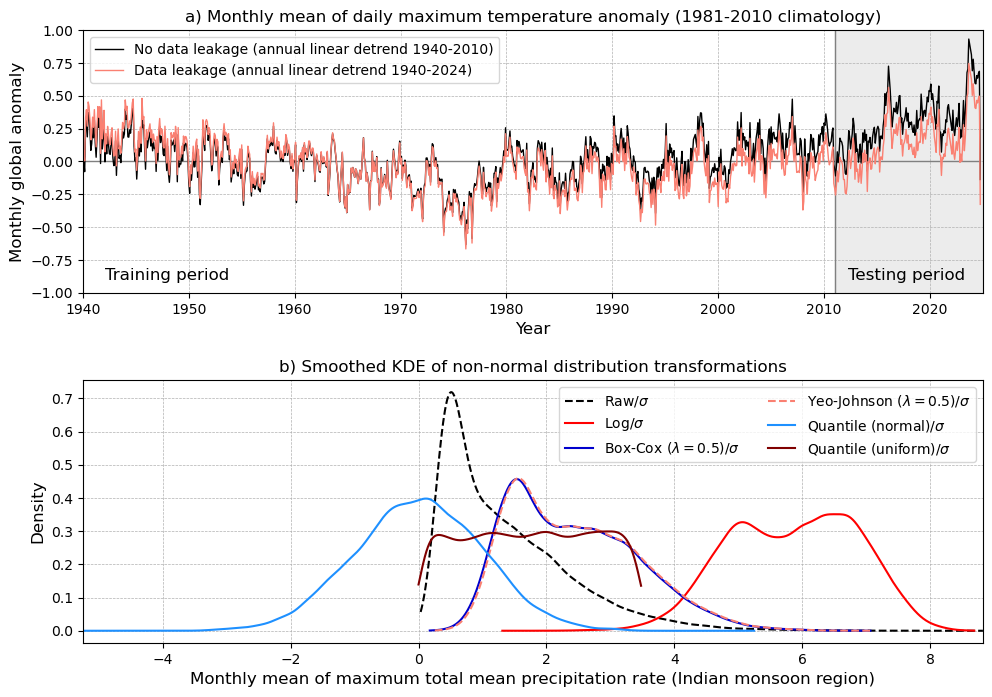

In [21]:
########################################## open time series monthly 2m temp max

dsts = xr.open_dataset("/glade/derecho/scratch/molina/bams_timeseries_sample.nc")['MX2T']

# 1981-2010 fixed monthly climatology
clim1 = dsts.sel(datetime=slice("1981-01-01", "2010-12-31")).groupby('datetime.month').mean(skipna=True)
an1 = dsts.groupby('datetime.month') - clim1

########################################## figure time
########################################## figure time
########################################## figure time

fig = plt.figure(figsize=(9,7))

##########################################

ax1 = fig.add_axes([0., 0.5, 1, 0.375])

ax1.axvspan(2011, 2025, color='gray', alpha=0.15)

# plot horizontal line at zero
ax1.hlines(
    y=0, 
    xmin=month_year_create(an1.datetime.dt.year.values)[0], 
    xmax=month_year_create(an1.datetime.dt.year.values)[-1], 
    lw=1, ls='-', colors='grey'
)

# plot horizontal line at zero
ax1.vlines(
    x=2011, 
    ymin=-1, 
    ymax=1, 
    lw=1, ls='-', colors='grey'
)

trend_data = an1.sel(datetime=slice("1940-01-01", "2010-12-31")).resample(datetime="YS").mean(skipna=True)
x_trend = trend_data.datetime.dt.year.values
coeffs = np.polyfit(x_trend, trend_data, deg=1)

line_1_ = an1 - np.polyval(coeffs, month_year_create(an1.datetime.dt.year.values))

ax1.plot(
    month_year_create(an1.datetime.dt.year.values), 
    line_1_, 
    c='k', lw=1., label="No data leakage (annual linear detrend 1940-2010)"
)

trend_data = an1.resample(datetime="YS").mean(skipna=True)
x_trend = trend_data.datetime.dt.year.values
coeffs = np.polyfit(x_trend, trend_data, deg=1)

line_2_ = an1 - np.polyval(coeffs, month_year_create(an1.datetime.dt.year.values))

ax1.plot(
    month_year_create(an1.datetime.dt.year.values), 
    line_2_, 
    c='salmon', lw=1., label="Data leakage (annual linear detrend 1940-2024)"
)

ax1.set_ylabel('Monthly global anomaly', fontsize=12)
ax1.set_xlabel('Year', fontsize=12)
ax1.grid(ls='--', lw=0.5)
ax1.margins(x=0, y=0)
ax1.annotate(
    'Training period', fontsize=12, 
    xy=(0.025, 0.05), xycoords='axes fraction', 
    xytext=(0.025, 0.05), textcoords='axes fraction'
)
ax1.annotate(
    'Testing period', fontsize=12, 
    xy=(0.85, 0.05), xycoords='axes fraction', 
    xytext=(0.85, 0.05), textcoords='axes fraction'
)
ax1.set_title('a) Monthly mean of daily maximum temperature anomaly (1981-2010 climatology)', fontsize=12)
ax1.legend()

##########################################
##########################################
##########################################

# RAW DATA
dstp = xr.open_dataset("/glade/derecho/scratch/molina/bams_mtpr_timeseries_sample.nc")

# no transform, just divided by std
data1 = dstp["MTPR"] / dstp["MTPR"].std()

# log transform, just divided by std
data2 = np.log(dstp["MTPR"].where(dstp["MTPR"] > 0)) / np.log(dstp["MTPR"].where(dstp["MTPR"] > 0)).std()

# box-cox transform, just divided by std
data3 = boxcox_transform(dstp["MTPR"], lam=0.5) / boxcox_transform(dstp["MTPR"], lam=0.5).std()

# yeo-johnson transform, just divided by std
data4 = yeo_johnson_transform(dstp["MTPR"], lam=0.5) / np.std(yeo_johnson_transform(dstp["MTPR"], lam=0.5))

# quantile normal transform, just divided by std
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
transformed_data = quantile_transformer.fit_transform(dstp["MTPR"].values.reshape(-1, 1)).flatten()
data5 = transformed_data / np.std(transformed_data)

# quantile uniform transform, just divided by std
quantile_transformer = QuantileTransformer(output_distribution='uniform', random_state=0)
transformed_data = quantile_transformer.fit_transform(dstp["MTPR"].values.reshape(-1, 1)).flatten()
data6 = transformed_data / np.std(transformed_data)

# data to plot
x1, y1 = compute_kde(data1)
x2, y2 = compute_kde(data2)
x3, y3 = compute_kde(data3)
x4, y4 = compute_kde(data4)
x5, y5 = compute_kde(data5)
x6, y6 = compute_kde(data6)

##########################################

ax2 = fig.add_axes([0., 0., 1, 0.375])

ax2.plot(x1, y1, color="k", ls="--", lw=1.5, label=r"Raw/$\sigma$")
ax2.plot(x2, y2, color="r", lw=1.5, label=r"Log/$\sigma$")
ax2.plot(x3, y3, color="mediumblue", lw=1.5, label=r"Box-Cox ($\lambda=0.5$)/$\sigma$")
ax2.plot(x4, y4, color="salmon", ls="--", lw=1.5, label=r"Yeo-Johnson ($\lambda=0.5$)/$\sigma$")
ax2.plot(x5, y5, color="dodgerblue", lw=1.5, label=r"Quantile (normal)/$\sigma$")
ax2.plot(x6, y6, color="maroon", lw=1.5, label=r"Quantile (uniform)/$\sigma$")

ax2.set_title("b) Smoothed KDE of non-normal distribution transformations", fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_xlabel('Monthly mean of maximum total mean precipitation rate (Indian monsoon region)', fontsize=12)
ax2.margins(x=0)
ax2.grid(ls='--', lw=0.5)
ax2.legend(ncol=2)

##########################################

plt.savefig('bams_fig1_2025.png', transparent=True, bbox_inches='tight') 
plt.show()

##########################################
##########################################
##########################################